# Генерация кода по вопросам со StackOverflow


Научим нейронную сеть отвечать на вопросы про языки программирования. 

Самые популярные sequence to sequence модели — это модели вида "encoder-decorder". Они используют RNN для того, чтобы закодировать входную последовательность в некоторый вектор. Этот вектор — представление входного предложения в некоторым заранее зафиксированном формате. Затем этот вектор декодируется второй RNN (декодером), который учится предсказывать выходную последовательность, генерируя последовательно токен за токеном. Давайте немного вспомним лекцию и освежим в памяти простой пример с машинным переводом. Перевод вопроса со StackOverflow на язык python будет проходить по концептуально такой же схеме, как и перевод с немецкого на английский, если мы говорим про использование seq2seq моделей. На картинке вы можете видеть пример перевода с помощью seq2seq модели. На вход мы подаём фразу "gutten morgen" ("доброго утра") — фразу на немецком языке. В энкодер она подается слово за словом. Кроме того, в начало предложения мы добавляем тэг "start of sequence" (коротко — SOS), а в конец мы добавляем токен "end of sequence" (EOS). В каждый момент времени, входом энкодера является текущей токен — назовём его "x", а также некоторое скрытое состояние — назовём его "h" (от слова "hidden"). Причём, в каждый момент времени мы подаём скрытое состояние с предыдущего шага. Выходом будет являться новое скрытое состояние. Скрытое состояние содержит в себе информацию обо всём предложении, которую сеть видела к текущему моменту. Нулевое скрытое состояние можно инициализировать нулями или использовать, например, равномерное распределение. Как только последнее слово было передано в RNN, будем использовать последнее скрытое состояние как вектор, содержащий в себе информацию обо всём предложении. Имея такой вектор, можно начинать декодировать его — генерировать выходную последовательность с помощью декодера. Давайте посмотрим на картинку — в каждый момент времени в мы подаём текущее слово и скрытое состояние с предыдущего шага. При этом, нулевое скрытое состояние декодера равно последнему скрытому состоянию энкодера. И энкодер и декодер мы можем представить как функции от x и h, то есть от текущего входного слова и скрытого состояния. В декодере на каждом шаге нам нужно предсказывать следующее слово. Для этого будем на каждом шаге пропускать текущее скрытое состояние через линейный слой и предсказывать следующее слово. После того как мы сгенерировали всю выходную последовательность, мы можем сравнить её с переводом из нашей обучающей выборки. Затем посчитаем функцию потерь и обновим веса сети, проделав в backward-шаг и посчитав градиент функции потерь.Остаётся только упомянуть о некоторых фишках, которые позволяют сделать процесс обучения декодера чуть более простым и понятным. Вспомним что такое "teacher forcing".[1,2] Это достаточно простая идея. Давайте в качестве некоторых токенов выходной последовательности иногда использовать "ground truth" из нашего датасета, а иногда — слово предсказанное нашим декодером. Таким образом, наша сеть периодически будет получать некоторую дополнительную информацию из нашей обучающей выборки. Ещё один небольшой трюк — это подход, который касается длины генерируемой последовательности. При генерации выходной последовательности не обязательно ждать, пока модель сгенерирует end-of-sequence токен. Можно, вместо этого, прекратить генерацию, когда мы выдали достаточное количество слов. Например, когда длина выходной последовательности стала примерно равна длине и входной последовательности. Это позволит нам избежать слишком долгого обучения, либо генерирования излишнего количества символов в конце нашей последовательности.  

[1] Williams R. J., Zipser D. A learning algorithm for continually running fully recurrent neural networks //Neural computation. – 1989. – Т. 1. – №. 2. – С. 270-280.  
[2] Lamb A. M. et al. Professor forcing: A new algorithm for training recurrent networks //Advances In Neural Information Processing Systems. – 2016. – С. 4601-4609.

Теперь давайте закодируем этот алгоритм с помощью библиотек pytorch и "torchtext". Обучать сеть мы будем не для стандартной (и немного надоевшей) задачи машинного перевода, а для чуть более сложной задачи ответов на вопросы со StackOverflow. Итак, сначала импортируем все библиотеки, которые нам могут понадобиться (это "torch", "torchtext" и некоторые другие библиотеки). После этого задаём "random.seed" для воспроизводимости результатов. 

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time

SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Прочитаем CSV с помощью библиотеки pandas. Он лежит в папке data. Откроем файл с тестовой выборкой и посмотрим на первые три строки из неё. Мы видим, что в нашем датасете есть два поля: intent и snippet. Intent — это, собственно, вопрос со StackOverflow, а snippet — это кусочек кода, который отвечает на этот вопрос. Теперь нам нужно написать токенизаторы, которые помогут нам поделить на токены вопросы со StackOverflow и кусочек кода. Функция "tokenize_question" токенизирует наш вопрос — делаем это с помощью простой регулярки. Кроме того, мы отрезаем слишком длинные слова, которые, скорее всего, являются названиями веб-сайтов, либо слишком длинными названиями каких-то текстовых полей и тд. Кроме того, мы будем подавать наш вопрос в обратном порядке в нашу сеть. То есть, будем начинать с последнего слова и заканчивать первым. Функция "tokenize_snippet" токенизирует кусочек кода. Работает она примерно так же, с помощью чуть другой регулярки, где мы перечисляем знаки пунктуации, которые нас могут интересовать. 

In [2]:
import re

def tokenize_question(text):
    """
    Tokenizes question from a string into a list of strings (tokens) and reverses it
    """
    return list(filter(lambda x: len(x) < 16, re.findall(r"[\w']+", text)[::-1]))

def tokenize_snippet(text):
    """
    Tokenizes code snippet into a list of operands
    """
    return list(filter(lambda x: len(x) < 10, re.findall(r"[\w']+|[.,!?;:@~(){}\[\]+-/=\\\'\"\`]", text)))

Напишем обработчик входных данных с помощью библиотеки "torchtext". Torchtext позволяет сделать это достаточно быстро и с минимальным числом строк кода. Field позволяет нам определить, как должны обрабатываться данные. Напишем два разных обработчика для вопросов на естественном языке и для кода. Intent, то есть текстовый вопрос — это исходная последовательность, назовём её "src" (source), а код назовём "trg" (target). Field позволяет задать параметр tokenize, куда мы можем передать наши функции-токенизаторы отдельно для вопроса или для кода. В нашем примере, Field также добавит два дополнительных токена — это "end of sequence" и "start of sequence". Все токены будут приведены к нижнему регистру, а также, для вопроса, мы будем учитывать длину этого вопроса. Таким образом, "field" будет возвращать нам пары, а именно — вопрос и его длина. В дальнейшем это нам понадобится для обучения seq2seq модели. Далее разделим наши данные на обучающую, валидационную и тестовую выборки. Это уже сделано за нас, наша выборка поделена на 3 CSV-файла, и всё, что нам нужно — это, всего лишь, скачать эти данные с помощью, например, "data.TabularDataset". Данные мы собрали из следующего источника — он называется CoNaLa-corpus, это объединённый проект лаборатории из Carnegie Mellon и лаборатории со смешным названием STRUDEL. Этот датасет достаточно маленький, включает в себя всего 2.5 тысячи примеров. Мы поделили их следующим образом: 2000 на обучение, примерно 350 на валидацию и 500 на тест. Кроме того, данные с похожей тематикой можно найти, загуглив следующее сочетание слов: "StackOverflow question code dataset". Это датасет, намайненный автоматически со StackOverflow, с помощью "Bi-View Hierarchical Neural Network". Cтатья про "bi view hierarchical neural network" была представлена в 2018 году[1], её авторы — сотрудники университетов Огайо, Вашингтона и компании Fujitsu, и их датасет включает в себя гораздо больше данных (там есть около 150 тысяч пар вопрос и сниппет на python и около 120 тысяч пар вопросов и ответов на SQL). Для обучения мы оставили только пары из первого датасета, так как он был собран вручную, гораздо менее шумный и позволяет обучить seq2seq модели с большим качеством. Второй датасет необходимо предварительно чистить, чтобы получить гораздо более хорошее качество. Вы можете попробовать выкачать этот датасет и обучить модель с использованием большего количества данных и посмотреть на результат — посмотреть на метрики, которые вас получатся.  

[1] Yao Z. et al. Staqc: A systematically mined question-code dataset from stack overflow //Proceedings of the 2018 World Wide Web Conference. – 2018. – С. 1693-1703.


Выберите правильные утверждения про загрузку данных через torchtext.data.TabularDataset

+Неважно, заглавными или маленькими буквами прописывать формат входных данных в поле format (оба варианта format='csv' и format='CSV' сработают)  
+В качестве формата входных данных можно использовать CSV, TSV или JSON  
-При использовании torchtext.data.TabularDataset.splits(...) нужно обязательно указать пути до файлов с обучающей, валидационной и тестовой выборками (параметры train, validation, test). Поделить выборку две части (train и test) нельзя  
-Обязательными параметрами являются path, format, fields, skip_header  


In [3]:
import torch
from torchtext.legacy import data, datasets

SRC = data.Field(
    tokenize = tokenize_question, 
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
    include_lengths = True
)

TRG = data.Field(
    tokenize = tokenize_snippet, 
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True
)

fields = {
    'intent': ('src', SRC),
    'snippet': ('trg', TRG)
}

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
train_data, valid_data, test_data = data.TabularDataset.splits(
                            path = 'datasets/stackoverflow_code_generation/conala/',
                            train = 'conala-train.csv',
                            validation = 'conala-valid.csv',
                            test = 'conala-test.csv',
                            format = 'csv',
                            fields = fields
)

Теперь сформируем словарь. Задаём максимально возможный размер слоя и минимальную встречаемость слова для того, чтобы попасть в словарь. Для вопроса мы выбираем минимальную встречаемость равную "3", для сниппета с кодом — "5". Эти числа можно вариировать и постараться подобрать такие, чтобы словарь выглядел наиболее адекватно — чтобы в нём не было мусорных слов, и чтобы, при этом, не отрезались слова, которые действительно несут некоторый смысл и помогут нам обучить более адекватную модель. Кроме того, для того, чтобы использовать паддинг, "torchtext" требует, чтобы все элементы в батче были отсортированы по их длине до применения паддинга, в убывающем порядке. То есть, первая последовательность должна быть самой длинной. 

In [4]:
SRC.build_vocab([train_data.src], max_size=25000, min_freq=3)
print(SRC.vocab.freqs.most_common(20))


TRG.build_vocab([train_data.trg], min_freq=5)
print(TRG.vocab.freqs.most_common(20))

print(f"Уникальные токены в словаре интентов: {len(SRC.vocab)}")
print(f"Уникальные токены в словаре сниппетов: {len(TRG.vocab)}")

[('a', 1285), ('in', 949), ('python', 922), ('to', 851), ('how', 633), ('of', 602), ('list', 558), ('string', 397), ('the', 328), ('from', 275), ('with', 228), ('pandas', 192), ('i', 191), ('dictionary', 162), ('get', 151), ('convert', 134), ('values', 131), ('do', 125), ('dataframe', 111), ('into', 110)]
[(')', 3480), ('(', 3475), ('.', 2595), (',', 1899), ('[', 1122), (']', 1121), ('=', 927), ("'", 885), ('\\', 697), (':', 587), ('in', 504), ('x', 498), ('"', 496), ('for', 450), ('1', 377), ('-', 279), ('a', 265), ('0', 259), ('/', 257), ('df', 234)]
Уникальные токены в словаре интентов: 612
Уникальные токены в словаре сниппетов: 395


In [5]:
print(f"Размер обучающей выборки: {len(train_data.examples)}")
print(f"Размер валидационной выборки: {len(valid_data.examples)}")
print(f"Размер тестовой выборки: {len(test_data.examples)}")

Размер обучающей выборки: 2000
Размер валидационной выборки: 379
Размер тестовой выборки: 500


Посмотрим, сколько уникальных токенов в словаре интентов и в словаре сниппетов. Оказывается, что их 754 и 551 (выглядит вполне адекватно для выборки, состоящей из чуть более чем 2000 вопросно-ответных пар). Также мы можем посмотреть на размеры наших обучающей, валидационной и тестовой выборки. Последний этап нашей простой предобработки данных — это создать итераторы. Мы хотим, чтобы итератор возвращал батчи с данными, у которых есть атрибут "src" — это тензоры, кодирующие входные предложения (вопросы на естественном языке) и атрибут "trg" (target) — это тензоры, кодирующие сниппеты с кодом. Под кодированием здесь понимается простое сопоставление токена его числовому индексу. Это соответствие, собственно, и прописано в слове. Удобно, что torchtext-итераторы умеют автоматически добавлять паддинг (делать все последовательности одной длины). Мы будем использовать "BucketIterator" (здесь), а не обычный итератор, потому что он минимизирует количество паддинга для входных и выходных предложений, что достаточно удобно в нашей задаче.  

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)
device

device(type='cuda')

In [7]:
BATCH_SIZE = 2

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

Рассмотрим код энкодера и декодера модели. Итак, энкодер, в нашем случае — это двухслойная LSTM. В статье, которая упоминается в начале семинара, использовалась четырёхслойная сеть, но мы попробуем сэкономить время на обучении сети и обучим двухслойную сетку. Для многослойной LSTM входная последовательность идёт в первый слой сети, а скрытое состояние первого слоя используется как входная последовательность следующего слоя. Скрытое состояние первого слоя можно представить формулой, зависящей от входных токенов и от предыдущего скрытого состояния. Напомню что, в отличие от RNN, LSTM, кроме того, что берёт на вход предыдущее скрытые состояние и возвращает следующее, ещё и принимает на вход так называемое "cell state". Его обычно обозначают буквой "c". Можно воспринимать его как другой вид скрытого состояния. В итоге, конечное представление входной последовательности в виде вектора будет конкатенацией скрытого состояния и нашего cell state, которое будем обозначать буквой "с".

Итак, создаём модуль "encoder". Он наследуется от "torch.nn.module" и энкодер принимает на вход следующие параметры. Это входная размерность данных — это размерности наших "one-hot" векторов, которая совпадает с размерностью словаря интентов; это размерность эмбеддингов, размерность слоя с эмбеддингами — например, можно сделать его равным 100 или 200, любому другому числу, которое кажется вам наиболее подходящим. Есть параметр, который называется "encoding hidden dimension" (вот он) — это размерность скрытого состояния; есть то же самое для декодера; и "dropout" — это количество дропаута, которое мы будем использовать. Здесь мы должны задать число от 0 до 1. Слой эмбеддингов создаётся с помощью "nn.embedding" . Дальше мы используем GRU-слой, вместо него можно с таким же успехом использовать LSTM. Дропаут будем добавлять между слоями нашей многослойной сети, то есть между скрытыми состояниями, которые идут на вход слою "2". Дальше — давайте рассмотрим метод "forward". В метод "forward" мы передаём входное предложение, которое превращено в dense-вектора с помощью эмбеддинг-слоя, и затем применяем дропаут (вот здесь). После того, как мы передали всю входную последовательность в RNN, она автоматически посчитает скрытое состояние по всей последовательности. Мы не передаём то, чем нужно инициализировать скрытое состояние. По дефолту тензоры инициализируются нулями, что нас вполне устраивает в этом примере. Сеть нам возвращает две вещи — это "outputs" и скрытый слой. Размерности каждого тензора прописаны в коде в виде комментариев, что упрощает процесс дебага и его осмысление. Ещё один параметр, который нужно упомянуть, называется "bidirectional". Он отвечает за то — двунаправленная или однонаправленная сеть используется нашем примере. 

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        #src_len = [src sent len]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        
        packed_outputs, hidden = self.rnn(packed_embedded)
                     
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

Кроме того, в нашем примере мы используем attention. В этом модуле мы будем считать веса attention. В нашем примере мы будем использовать attention. На коде attention не будем останавливаться подробно, скажем лишь, что здесь мы будем использовать стандартный attention, который посчитает нам веса по нашей входной последовательности. 

In [9]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
                
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
            
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

Архитектура декодера аналогична архитектуре энкодедра — это GRU unit, первый слой получает пару с прошлого шага и прогоняет её через нашу сеть вместе с текущим токеном, чтобы предсказать новую пару — таким образом, уравнения декодера будут очень похожи на уравнения энкодера. Затем мы прогоняем наше скрытое состояние с верхнего слоя через линейный слой, чтобы сделать предсказание следующего токена в выходном генерируемом предложении. Входные аргументы класса "decoder" похоже на аргументы класса "encoder", исключения — у нас здесь есть параметр, который называется "output_dimension" (это размер one-hot векторов, которые подаются на вход декодеру). Это число должно быть равно размеру словаря таргета. Forward-метод декодера принимает батч входных данных, а также скрытое состояние с предыдущего шага. Мы применяем unsqueeze к выходным токенам, чтобы добавить ещё одну размерность. Далее, аналогично энкодеру, применяем эмбеддинг-слой и дропаут. Дальше применяем attention, и потом батч с токенами передаём в RNN вместе с "h" и "c" векторами с предыдущего шага. Аналогично энкодеру, мы получаем на выходе output (это скрытое состояние с верхнего слоя нашей сети), новое скрытое состояние и новое cell состояние, то есть новые вектора "h" и "c". И мы прогоняем output (после того, как избавились от лишней размерности) через линейный слой, чтобы получить предсказание следующего слова в нашей последовательности. И возвращать здесь мы будем, собственно — output, скрытое состояние и вектор "а". 

In [10]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

Модуль для seq2seq модели. Она будет содержать внутри себя энкодер, декодер и уметь обрабатывать входные последовательности (то есть вопросы) и выдавать сниппеты в качестве ответов. Входные параметры seq2seq модели —это энкодер, декодер, device, а также токены, с помощью которых мы кодируем паддинг, начало последовательности и конец последовательности. В этой имплементации их можно менять. Нам нужно убедиться, что количество слоёв и размерность скрытых состояний — одинакова для энкодера и декодера. Это не обязательное условие, но в противном случае (в случае разного количества слоёв) нам придётся придумывать некоторые способы это обойти. Например, если в энкодере два слоя, а в декоре один, то можно использовать оба вектора, либо можно их усреднить. "forward"-метод в классе seq2seq берёт на вход вопрос, сниппет с кодом и "teacher forcing ratio". На выход он отдаёт нам output, а также веса attention, которые мы посчитали в модуле attention. 

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
            trg = torch.zeros((100, src.shape[1])).long().fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            output, hidden, attention = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output
            attentions[t] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

Теперь мы можем инициализировать модель. Как сказано ранее, входная и выходная размерность определяются размерами словарей. Сделаем так, чтобы количество слоёв у энкодера и декодера, а также размерности векторов скрытых состояний были одинаковыми. Давайте зададим размерность скрытого состояния равную "100", размерность для эмбеддингов — "256". Также зададим dropout — он будет достаточно большим ("0.8"). Далее мы увидим, что если ставить дропаут достаточно маленьким, то сеть будет плохо учиться и результат будет достаточно некрасивым. 

In [12]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 100
DEC_HID_DIM = 100
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
PAD_IDX = SRC.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

Теперь инициализируем веса для обеих моделей. В статье, которую мы пытаемся имплементировать, брали равномерное распределение от -0.08 до +0.08. Создадим функцию "init_weights" и добавим её в нашу модель с помощью метода apply. Равномерное распределение мы берём из nn.init.uniform (то есть, берём просто равномерное распределение из pytorch). 


In [13]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(612, 128)
    (rnn): GRU(128, 100, bidirectional=True)
    (fc): Linear(in_features=200, out_features=100, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=300, out_features=100, bias=True)
    )
    (embedding): Embedding(395, 128)
    (rnn): GRU(328, 100)
    (out): Linear(in_features=428, out_features=395, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
)

Также посчитаем количество параметров, которое содержит наша модель. У нас получилось около 1 миллиона параметров — достаточно много, но замечательно, что у нас достаточно высокий процент дропаута, это поможет нам не переобучиться. 

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель содержит {count_parameters(model):,} параметров')

Модель содержит 615,651 параметров


В качестве оптимизатора будем использовать Adam, в качестве loss-функции — кросс энтропию. 

In [15]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

Теперь мы можем написать функцию, которая задаст наш цикл обучения. Сначала мы переводим модель в training mode (с помощью model.train). Это включит dropout и батч-нормализацию (если бы она была, но, в нашем случае, мы её не используем). А потом будем итерироваться через батч-итератор. Что мы делаем на каждой итерации? На каждой итерации мы берём входное и выходное предложение из батча, вместо входного предложения мы получаем пару — "входное предложение и его длина" (как мы уже обсуждали ранее). Далее мы делаем zero_grad — обнуляем градиенты, посчитанные на предыдущем шаге, затем мы передаём source и target в нашу модель и получаем некоторый выход и веса attention, мы считаем градиенты с помощью "loss backward", предварительно посчитав функцию потерь, и дальше клипаем (clip) градиенты, делаем шаг нашим оптимизатором и считаем лосс. Замечательно, на выход наша функция будет возвращать нормализованный лосс по нашей эпохе. 

In [16]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len.to('cpu'), trg, 0.4)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Также у нас есть функция, которую мы будем использовать для оценивания качества модели (для evaluate). Здесь, вначале, мы переводим нашу модель в состояние оценивания качества (это означает "выключить dropout", "выключить батч-нормализацию") и дальше проделываем примерно такие же шаги, как и в функции "train". 

In [17]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output, attention = model(src, src_len.to('cpu'), trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Кроме того, давайте напишем функцию, которая будет замерять время, потраченное на каждую эпоху, и назовём её "epoch_time".

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Можем начать тренировать нашу модель. На каждой итерации будем печатать перплексию (увидеть разницу в перплексии гораздо проще, чем в кросс-энтропии, поскольку она по порядку больше). На каждой итерации мы будем печатать перплексию, а в конце каждой эпохи будем проверять, получила ли наша модель score лучше, чем во всех предыдущих эпохах. Если это произошло, мы обновим переменную best_valid_loss и сохраним параметры лучшей модели с помощью вызова функции state dict. Потом, когда мы будем оценивать качество моделей на тестовой выборке, загрузим параметры той модели, которая давала наилучший валидационный score (сделать мы это сможем с помощью вот этого кода - через одну ячейку).  

In [19]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

# for epoch in range(N_EPOCHS):
    
#     start_time = time.time()
    
#     train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
#     valid_loss = evaluate(model, valid_iterator, criterion)
    
#     end_time = time.time()
    
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'models/5.5.conala_model_attention_test.pt')
    
#     print(f'Эпоха: {epoch+1:02} | Время: {epoch_mins}m {epoch_secs}s')
#     print(f'Перплексия (обучение): {math.exp(train_loss):7.3f}')
#     print(f'Перплексия (валидация): {math.exp(valid_loss):7.3f}')

На обучении наш лосс падает, на валидации — тоже. При этом, если мы посмотрим, что происходит в процессе обучения — под конец обучения лосс на валидации практически перестаёт падать и, в принципе, выходит на некоторое плато — начинает флуктуировать. Лосс на трейне всё ещё продолжает падать, но, при этом, тоже начинает немного флуктуировать.   
Отлично, мы обучили модель, теперь мы можем посмотреть, какой лосс она даёт на тестовой выборке — он примерно равен лоссу на валидации и перплексия на тесте — выше, чем перплексия на обучении. В принципе, это достаточно ожидаемый результат. 

In [20]:
model.load_state_dict(torch.load('models/5.5.conala_model_attention_test.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Перплексия (валидация): {math.exp(test_loss):7.3f}')

Перплексия (валидация):  29.741


## Предсказание кода по вопросу

Функция, которая будет генерировать кодовый сниппет по нашему вопросу. И наконец — посмотреть, какое же качество получилось у нашей модели. Напишем функцию "translate sentence", которая будет по токенизированному вопросу выдавать ответ на этот вопрос на языке программирования. То есть, выдавать кодовый сниппет, который отвечает на наш вопрос. 

In [21]:
def translate_sentence(model, sentence):
    model.eval()
    tokenized = tokenize_question(sentence) 
    tokenized = ['<sos>'] + [t.lower() for t in tokenized] + ['<eos>']
    numericalized = [SRC.vocab.stoi[t] for t in tokenized] 
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) 
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length.to('cpu'), None, 0) 
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [TRG.vocab.itos[t] for t in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

Функция, которая будет визуализировать веса attention, то есть, мы сможем посмотреть, какие слова имеют больший вес относительно каких слов. 

In [22]:
def display_attention(candidate, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in tokenize_question(candidate)] + ['<eos>'], 
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Давайте возьмём 3 произвольных примера из обучающей, валидационной и тестовой выборки, и посмотрим, что у нас получилось. Мы берём пример из обучающей выборки. Вопрос звучит как "how to convert today daytime string back to datetime object". Ответ должен быть примерно вот таким — то есть мы должны использовать модуль "datetime", вызвать оттуда функцию "strptime". 

In [23]:
example_idx = 2

src = ' '.join(vars(train_data.examples[example_idx])['src'])
trg = ' '.join(vars(train_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = object datetime to back string datetime a convert to how
trg = datetime . strptime ( '2010 - 11 - 13 10 : 33 : 54 . 227806' , ' y - m - d h : m : s . f' )


Наша сеть смогла предсказать, что нам нужно использовать функцию daytime.strptime, что достаточно хорошо, но, при этом, у неё в словаре нету вот этих чисел, которые, скорее всего, встретились в нашей выборке один или два раза, и поэтому не попали в наш словарь, и из-за этого наша сеть не может ничего написать в скобках функции — она не имеет в словаре вот этих символов. Достаточно ожидаемый результат. 

predicted trg =  datetime . datetime . strptime ( <unk> ) <unk> m : m : m - m h : m : m h : m : m h : m : m h : m : <unk> h : m : <unk> h : m : <unk> h : m : <unk> ) <unk> )


/home/dmitry/anaconda3/envs/stpk_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/dmitry/anaconda3/envs/stpk_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


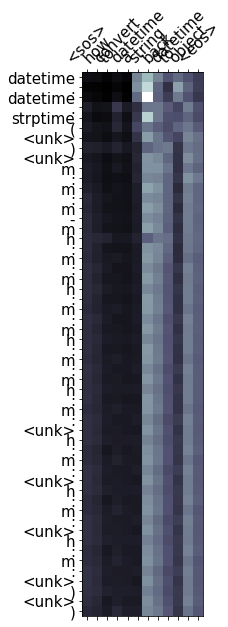

In [24]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ' '.join(translation))

display_attention(src, translation, attention)

Если мы посмотрим на матрицу attention — мы видим, что слова datetime являются ключевыми в этом вопросе, остальные слова практически никакого веса не вносят. 

Посмотрим на какой-нибудь вопрос из валидационной и тестовой выборки. Из за валидационной мы берём вопрос "python convert a tuple to string" (ОК, ответ должен быть примерно таким), Выглядит достаточно странно, но, в валидационной выборке он был именно таким. При этом, эта выборка собиралась руками, так что, наверное, какая-то логика в этом есть. 

In [25]:
example_idx = 8

src = ' '.join(vars(valid_data.examples[example_idx])['src'])
trg = ' '.join(vars(valid_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = string to tuple convert python
trg = " " " " " " . join ( ( 'a' , 'b' , 'c' , 'd' , 'g' , 'x' , 'r' , 'e' ) )


Наша сеть предсказывает вот такой ответ. Он не очень логичный, и он даже синтаксически никак не согласовывается, то есть здесь закрывается круглая скобка, хотя должна бы закрыться квадратная. Так что можно считать, что это не очень хороший пример. Здесь я постаралась показать не только хорошие примеры, которые обучились плюс-минус адекватно, но и любые остальные, чтобы было видно, что, всё-таки, сеть на таком маленьком количестве данных и проучившись небольшое количество эпох обучилась неидеально. 

predicted trg =  int ( ' , <unk> )


/home/dmitry/anaconda3/envs/stpk_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/dmitry/anaconda3/envs/stpk_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


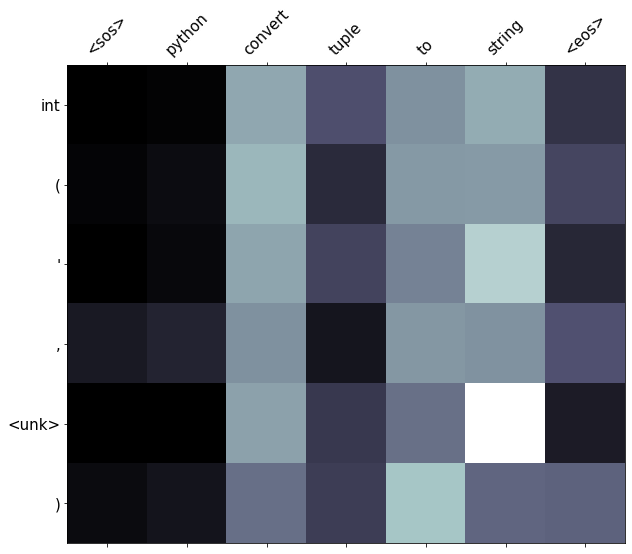

In [26]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ' '.join(translation))

display_attention(src, translation, attention)

Ну и давайте посмотрим на какой-нибудь пример из тестовой выборки, например — вопрос про то, как работать с кодировками UTF-8 (кодировкой, которая помогает нам работать с русскими символами). Ответ должен быть вот таким: сначала сделать "decode", потом "encode". 

In [27]:
example_idx = 4

src = ' '.join(vars(test_data.examples[example_idx])['src'])
trg = ' '.join(vars(test_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = 8 utf to 1251 cp from string a convert to how
trg = d . decode ( 'cp1251' ) . encode ( 'utf8' )


Наша сеть смогла предсказать decode (декодирование), но, при этом, почему-то она здесь поставила слова "soup". Возможно, как-то это коррелирует с библиотекой beautifulsoup и, как-то, нашей сети показалось, что это здесь будет уместно. 

predicted trg =  print('.<unk>(')


/home/dmitry/anaconda3/envs/stpk_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/dmitry/anaconda3/envs/stpk_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


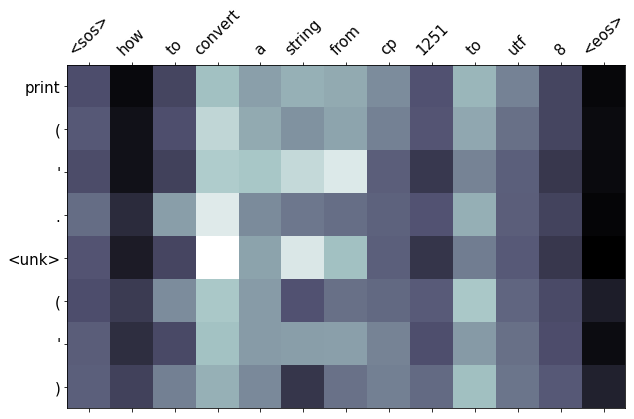

In [28]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ''.join(translation))

display_attention(src, translation, attention)

Если мы посмотрим на матрицу attention, то и здесь важно было только слово "UTF" — кажется, что если говорить про декодирование то слово "UTF" очень хорошо связано со словом "soup" (видимо, это отсылка к "beautifulsoup") и со словом "decode", с остальными скобками и "unknown token" немного — тоже. В предыдущем примере матрица attention выглядела примерно так же, то есть — слово "string", которое здесь было, видимо, ключевым, по мнению нашей сети было связано достаточно плотно, практически, со всеми остальными символами в нашем примере. Но учитывая, что это не слишком удачный пример, эта матрица не несёт достаточно информации

<img src="./img/Perplexion.png">  
  
+Можно использовать перплексию для сравнения двух нейросетей с разными архитектурами на одной и той же задачи (обе нейросети обучены переводить текст с языка А на язык Б)  
+Перплексия связного текста ниже, чем перплексия произвольного набора слов  
-Можно использовать перплексию для сравнения нейросетей с одинаковой архитектурой, где первая сеть решает задачу перевода с языка А на язык Б, а вторая с языка В на язык Г  
-Чтобы посчитать перплексию обязательно нужен ground truth (например, написанный человеком перевод текста). Другими словами, перплексию нельзя посчитать на данных без разметки.  

Выводы:  
seq2seq модели достаточно просто обучать. Можно использовать уже готовые модули из pytorch — например, GRU юниты или LSTM. Но, при этом, если мы используем недостаточно большое количество данных, либо мы учим модель недостаточно долго, либо мы подобрали неправильно параметры — например, использовали мало дропаута или наша модель переобучилась — мы не получим какого-то очень крутого результата. При этом, задача, для решения которой мы пытались здесь обучить сеть, достаточно сложная, и генерировать код по словесному описанию проблемы на естественном языке — это сложная задача, в принципе, даже для человека, не то что для нейронной сети. При этом, наша сеть научилась генерировать, в принципе, какие-то логичные ответы, то есть, зачастую, всплывают ключевые слова, которые действительно относятся к сути проблемы. Если использовать больший объём обучающих данных, а также немного поиграть с параметрами сети — наверняка, мы сможем получить гораздо более красивый результат. !

**Домашнее задание №1**

При обучении seq2seq модели из семинара качество работы модели оказалось не слишком хорошим. У этого есть несколько причин:

Слишком маленький датасет. На 2000 пар сложно обучить хорошую модель для решения такой сложной задачи.
Модель очень простая, есть смысл попробовать усложнить ее (использовать другие архитектуры, например, Трансформер, разобранный в предыдущих лекциях и семинарах).
Стоит более аккуратно подбирать параметры модели. Обратите внимание на:
 Процесс построения словаря. Может быть, нужно поварьировать параметры min_freq, max_freq.
Dropout. Есть ли смысл добавлять еще больше dropout в модель?
Стратегия изменения learning rate в процессе обучения.
В качестве домашнего задания мы предлагаем Вам поэкспериментировать с кодом этого семинара и улучшить качество работы модели. В репозитории курса выложены два датасета: один из них (conala, 2000 пар на обучение) был разобран видео, второй (StaQC, 50000 пар на обучение) Вам предлагается использовать в домашней работе. Для начала Вы можете проверить, помогает ли улучшить качество работы модели использование большего количества данных без каких-либо дополнительных улучшений.

Опишите то, что у Вас получилось, в ответе к этому шагу.

Балл за этот шаг зачитывается автоматически, вне зависимости от текста, который Вы впишете в поле ответа :)К тому же, после нажатия кнопки "Отправить" Вы получите доступ к ответам других участников и сможете обменяться своими находками.

Успехов! :)

**Домашнее задание №2**

Попробуйте адаптировать код из семинара для решения задачи перевода текстов с немецкого на английский язык. В качестве данных для обучения можно использовать датасет Multi30k. Скачать его можно с помощью следующего кода:

from torchtext.datasets import TranslationDataset, Multi30k


spacy_de = spacy.load('de')
spacy_en = spacy.load('en')


def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]


SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

train_data, valid_data, test_data = Multi30k.splits(
    exts = ('.de', '.en'), 
    fields = (SRC, TRG)
)
Обратите внимание, что здесь при создании SRC и TRG отсутствует параметр include_lengths. Для корректной работы с этим примером, Вам нужно будет немного изменить метод forward класса Encoder из кода семинара.

Опишите то, что у Вас получилось, в ответе к этому шагу.

Балл за этот шаг зачитывается автоматически, вне зависимости от текста, который Вы впишете в поле ответа :)

К тому же, после нажатия кнопки "Отправить" Вы получите доступ к ответам других участников и сможете обменяться своими находками.

Успехов! :)

